# Reading File

In [1]:
def readFile(fileName):
    file = open(fileName, encoding = 'utf-8')
    row = file.readline() #read all lines
    file.close()

    return row

# Creating Dataset

In [ ]:
import os
label = []
rows = []

#os.chdir("datas")

for file in os.listdir():
    # Check whether file is in text format or not
    print(file)
    if file.endswith(".txt"):
        file_path = "/content/datas/" + file
  
        # call read text file function
        row = readFile(file_path)
        rows.append(row)
        if file_path.find("norm") != -1:  label.append("ham")
        else: label.append("spam")

In [ ]:
len(rows)

1017

# Word Count

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
total_word = []
for txt in rows:
  text_tokens = word_tokenize(txt)
  for token in text_tokens:
    total_word.append(token)
print("Toplam kelime sayısı: " + str(len(total_word)))
total_words = list(set(total_word))
print("Unique kelime sayısı: " + str(len(total_words)))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Toplam kelime sayısı: 66870
Unique kelime sayısı: 19162


# Creating CSV files for training

In [ ]:
!pip install zeyrek
nltk.download('stopwords')

In [ ]:
import zeyrek
analyzer = zeyrek.MorphAnalyzer()

In [ ]:
import re
def editMail(row):
  match_mail = re.findall(r'[\w.+-]+@[\w-]+\.[\w.-]+', row)
  if len(match_mail) > 0:
    for mail in match_mail:
      row = row.replace(mail,"email")
  row = str(row).replace(".", ". ")
  row = str(row).replace(",", ", ")

  return row

In [ ]:
import csv
import nltk
import warnings
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

warnings.filterwarnings('ignore')
stop_words = set(stopwords.words('turkish'))
#create csv file
with open('spam_dataset.csv', 'w', newline='',encoding='utf-8') as file:
    fieldnames = ['labels', 'text']
    #define dictionary writer
    writer = csv.DictWriter(file, fieldnames=fieldnames)
    writer.writeheader()
    ind = 0
    #read row in files
    for row in rows:   
      #tokenize sentence
      row = editMail(row)
      row = row.translate(str.maketrans('', '', string.punctuation))
      text_tokens = word_tokenize(row)
      text_no_digit = [i for i in text_tokens if not i.isdigit()]
      #remove stopwords in sentence
      tokens_sw = [word.lower() for word in text_no_digit if not word.lower() in stop_words]
      #lemmatization 
      tokens_lemma = []
      for word in tokens_sw:
        try:
          results = analyzer.lemmatize(word)[0]
          lemma = results[1][0]
          tokens_lemma.append(lemma)
        except Exception as e:
          tokens_lemma.append(word.lower())     

      #remove stopwords in sentence
      tokens_without_sw = [word.lower() for word in tokens_lemma if not word.lower() in stop_words]
      #new sentence after processes
      filtered_sentence = (" ").join(tokens_without_sw)   
      writer.writerow({'labels': str(label[ind]), 'text': filtered_sentence})
      ind += 1

# Loading data for Turkish text classification and Create Dataframe

In [4]:
import pandas as pd

In [ ]:
df=pd.read_csv("spam_last.csv")
df.columns=["labels","text"]
df.labels=pd.Categorical(df.labels)
df['labels'] = pd.factorize(df.labels)[0]

In [ ]:
df.head()

,labels,text
0,0,sayın nolu kartınıza ait mart ayı ekstresine e...
1,0,onayın gecikti ürün bedeli satıcıya aktarıldı ...
2,1,taze perşembe fırsatları meyve sebzelerde tl i...
3,1,kampın şefi olmaya dersin merhaba ekotasarımlı...
4,0,çağrı merkezi talebiniz tamer değerli müşterim...


In [ ]:
!pip install simpletransformers

In [14]:
from simpletransformers.classification import ClassificationModel
import torch,sklearn
from sklearn.model_selection import train_test_split

In [10]:
train_df=pd.read_csv("spam_train.csv")
train_df.columns=["x","labels","text"]
train_df.labels=pd.Categorical(train_df.labels)
train_df['labels'] = pd.factorize(train_df.labels)[0]
eval_df=pd.read_csv("spam_eval.csv")
eval_df.columns=["x","labels","text"]
eval_df.labels=pd.Categorical(eval_df.labels)
eval_df['labels'] = pd.factorize(eval_df.labels)[0]

eval_df = eval_df.drop(labels=["x"], axis=1)
train_df = train_df.drop(labels=["x"], axis=1)

In [ ]:
# split a dataset into train and test sets
train_df, eval_df = train_test_split(df, test_size=0.2, random_state=42)
train_df.to_csv("spam_train.csv")
eval_df.to_csv("spam_eval.csv")

In [12]:
model_args = {
    "use_early_stopping": True,
    "early_stopping_delta": 0.01,
    "early_stopping_metric": "mcc",
    "early_stopping_metric_minimize": False,
    "early_stopping_patience": 5,
    "evaluate_during_training_steps": 1000,
    "fp16": False,
    'overwrite_output_dir': True,
    "num_train_epochs":3
}

# Training Language Models

In [15]:
modelb = ClassificationModel('bert', 'dbmdz/bert-base-turkish-cased', num_labels=2, args=model_args)
modelb.train_model(train_df, acc=sklearn.metrics.accuracy_score, f1=sklearn.metrics.f1_score)

modele = ClassificationModel('electra', 'dbmdz/electra-base-turkish-cased-discriminator', num_labels=2, args=model_args)
modele.train_model(train_df, acc=sklearn.metrics.accuracy_score, f1=sklearn.metrics.f1_score)

modela = ClassificationModel('albert', 'loodos/albert-base-turkish-uncased', num_labels=2, args=model_args)
modela.train_model(train_df, acc=sklearn.metrics.accuracy_score, f1=sklearn.metrics.f1_score)

model_db = ClassificationModel("distilbert", "dbmdz/distilbert-base-turkish-cased",args=model_args, num_labels=2)
model_db.train_model(train_df, acc=sklearn.metrics.accuracy_score, f1=sklearn.metrics.f1_score)

Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of the model checkpoint at dbmdz/bert-base-turkish-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were 

Downloading:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/251k [00:00<?, ?B/s]

  0%|          | 0/811 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/102 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/102 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/102 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/1.27k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/443M [00:00<?, ?B/s]

Some weights of the model checkpoint at dbmdz/electra-base-turkish-cased-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at dbmdz/electra-base-turkish-cased-discriminator and are newly i

Downloading:   0%|          | 0.00/83.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/251k [00:00<?, ?B/s]

  0%|          | 0/811 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/102 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/102 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/102 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/634 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.3M [00:00<?, ?B/s]

Some weights of the model checkpoint at loodos/albert-base-turkish-uncased were not used when initializing AlbertForSequenceClassification: ['predictions.bias', 'predictions.dense.bias', 'predictions.LayerNorm.bias', 'predictions.LayerNorm.weight', 'predictions.dense.weight', 'predictions.decoder.bias', 'predictions.decoder.weight']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at loodos/albert-base-turkish-uncased and are newly initialized: ['classi

Downloading:   0%|          | 0.00/863k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/156 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/71.0 [00:00<?, ?B/s]

  0%|          | 0/811 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/102 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/102 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/102 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/410 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/273M [00:00<?, ?B/s]

Some weights of the model checkpoint at dbmdz/distilbert-base-turkish-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at dbmdz/distilbert-base-turkish-cased and are newly initialized: ['classifier.weight', 'pre_class

Downloading:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/251k [00:00<?, ?B/s]

  0%|          | 0/811 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/102 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/102 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/102 [00:00<?, ?it/s]

(306, 0.2717907557087445)

# Testing BERT Language Model

In [23]:
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

  0%|          | 0/203 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/26 [00:00<?, ?it/s]

0.9408866995073891
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       102
           1       0.94      0.94      0.94       101

    accuracy                           0.94       203
   macro avg       0.94      0.94      0.94       203
weighted avg       0.94      0.94      0.94       203



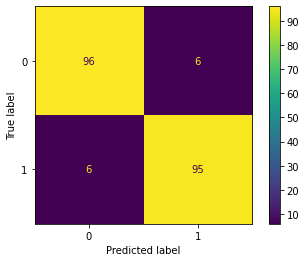

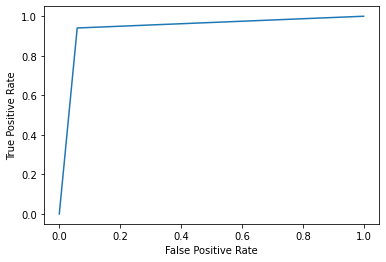

In [25]:
test = eval_df 
result, model_outputs, wrong_predictions = modelb.eval_model(test)
predictions = model_outputs.argmax(axis=1)
actuals = test.labels.values

print(accuracy_score(actuals, predictions))
print(classification_report(actuals, predictions))
cm_display = ConfusionMatrixDisplay(confusion_matrix(actuals, predictions)).plot()
print(cm_display)
fpr, tpr, thresholds = roc_curve(actuals, predictions)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
print(roc_display)

  0%|          | 0/203 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/26 [00:00<?, ?it/s]

0.9408866995073891
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       102
           1       0.94      0.94      0.94       101

    accuracy                           0.94       203
   macro avg       0.94      0.94      0.94       203
weighted avg       0.94      0.94      0.94       203



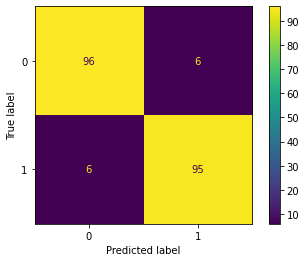

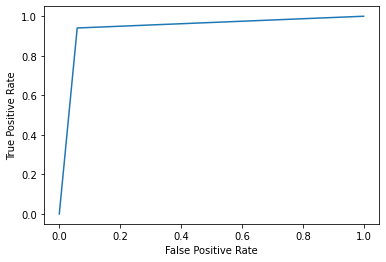

In [26]:
result, model_outputs, wrong_predictions = modele.eval_model(test)
predictions = model_outputs.argmax(axis=1)
actuals = test.labels.values

print(accuracy_score(actuals, predictions))
print(classification_report(actuals, predictions))
cm_display = ConfusionMatrixDisplay(confusion_matrix(actuals, predictions)).plot()
print(cm_display)
fpr, tpr, thresholds = roc_curve(actuals, predictions)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
print(roc_display)

  0%|          | 0/203 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/26 [00:00<?, ?it/s]

0.9310344827586207
              precision    recall  f1-score   support

           0       0.89      0.99      0.94       102
           1       0.99      0.87      0.93       101

    accuracy                           0.93       203
   macro avg       0.94      0.93      0.93       203
weighted avg       0.94      0.93      0.93       203



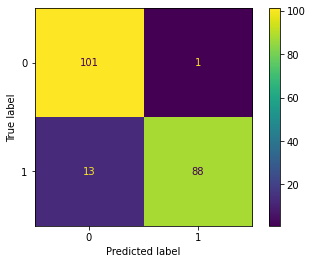

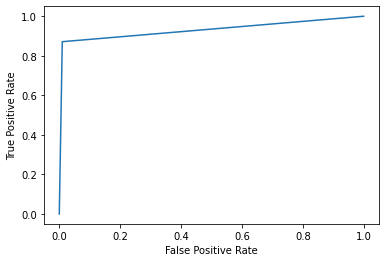

In [27]:
result, model_outputs, wrong_predictions = modela.eval_model(test)
predictions = model_outputs.argmax(axis=1)
actuals = test.labels.values

print(accuracy_score(actuals, predictions))
print(classification_report(actuals, predictions))
cm_display = ConfusionMatrixDisplay(confusion_matrix(actuals, predictions)).plot()
print(cm_display)
fpr, tpr, thresholds = roc_curve(actuals, predictions)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
print(roc_display)

  0%|          | 0/203 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/26 [00:00<?, ?it/s]

0.9359605911330049
              precision    recall  f1-score   support

           0       0.94      0.93      0.94       102
           1       0.93      0.94      0.94       101

    accuracy                           0.94       203
   macro avg       0.94      0.94      0.94       203
weighted avg       0.94      0.94      0.94       203



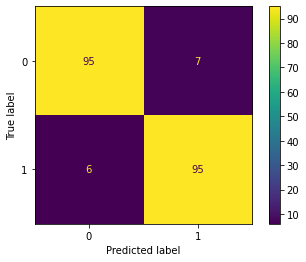

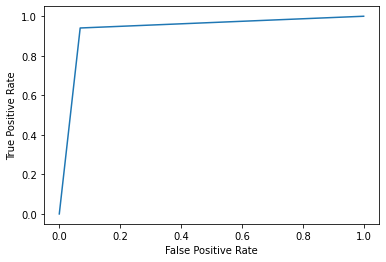

In [28]:
result, model_outputs, wrong_predictions = model_db.eval_model(test)
predictions = model_outputs.argmax(axis=1)
actuals = test.labels.values

print(accuracy_score(actuals, predictions))
print(classification_report(actuals, predictions))
cm_display = ConfusionMatrixDisplay(confusion_matrix(actuals, predictions)).plot()
print(cm_display)
fpr, tpr, thresholds = roc_curve(actuals, predictions)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
print(roc_display)

Sentence predict example

In [ ]:
sample_text = test.iloc[10]['text']
print(sample_text)
model.predict([sample_text])
test.iloc[10]['labels']